# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### Identical and Complement Fields in Observation Spaces

In [5]:
for index, s in enumerate(states):
    print('Observation of agent {}:\n{}\n'.format(index, s))

print('Identical fields:\n{}\n{}\n'.format(states[0][17],
                                        states[0][21]))

print('Complement fields:\n{}\n{}\n'.format(states[0][20],
                                     states[1][20]))

Observation of agent 0:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]

Observation of agent 1:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.4669857  -1.5         0.          0.
 -6.83172083  6.          0.          0.        ]

Identical fields:
-1.5
6.0

Complement fields:
6.83172082901001
-6.83172082901001



### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

Episode 100	Average Score:-0.009999999776482582	Execution Time:0:00:14.866217
Episode 200	Average Score:-0.0019999996572732924	Execution Time:0:00:17.013829
Episode 300	Average Score:-0.004999999701976776	Execution Time:0:00:16.532036
Episode 400	Average Score:-0.009999999776482582	Execution Time:0:00:15.205322
Episode 500	Average Score:-0.009999999776482582	Execution Time:0:00:15.327609
Episode 600	Average Score:-0.009999999776482582	Execution Time:0:00:15.200828
Episode 700	Average Score:-0.009999999776482582	Execution Time:0:00:15.279856
Episode 800	Average Score:-0.009999999776482582	Execution Time:0:00:15.257092
Episode 900	Average Score:-0.009999999776482582	Execution Time:0:00:15.521623
Episode 1000	Average Score:-0.009999999776482582	Execution Time:0:00:15.429779
Episode 1100	Average Score:-0.009999999776482582	Execution Time:0:00:15.497851
Episode 1200	Average Score:-0.009999999776482582	Execution Time:0:00:15.306808
Episode 1300	Average Score:-0.009999999776482582	Execution T

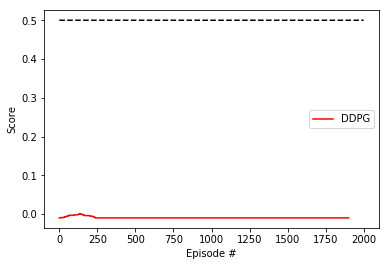

In [8]:
%load_ext autoreload
%autoreload 2

from utils.workspace_utils import active_session
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque
import numpy as np
from datetime import datetime
from utils import utils
from unity_env_decorator import UnityEnvDecorator
from agents.ddpg_agent_version_1 import DDPGAgentVersion1
from agents.agent_group import AgentGroup
from utils.utils import ScoreParcels

import pdb 

version='DDPG_version_1'
dir_logs='./logs/'
dir_checkpoints='./checkpoints/'

def ddpg(envDecorator, agentGroup, n_episode=2000, max_episode_length=2000, 
         print_every=100, size_window=100, baseline_score=0.5, save_best=True):
         

    max_score = 0.0
    scores_deque = deque(maxlen=size_window)
    scores = []
    
    
    # Declare time stamp for total execution time
    start_time_total = datetime.now()
    # Declare time stamp for execution time within 'print_every' episodes.
    start_time_window = datetime.now()
    
    
    for i_episode in range(1, n_episode+1):
        states = envDecorator.reset()
        agentGroup.reset()
        score = np.zeros(envDecorator.num_agents)
        
        for i_step in range(max_episode_length):
            # actions[0] = actions of agent_0.
            # actions[1]= actions of agent_1
            actions = agentGroup.act(states, add_noise=True)

#             pdb.set_trace()
            
            # next_states[0] = next_states of agent_0
            # next_states[1] = next_states of agent_1
            next_states, rewards, dones, _ = envDecorator.step(actions)

            agentGroup.step(states, actions, rewards, next_states, dones)
            
            score += rewards
            states = next_states
            
            if np.any(dones):
                break
                
        score_sum = np.sum(score)
        scores.append(score_sum)
        scores_deque.append(score_sum)
             
        print('\rEpisode {}\tReward:{}\tStep:{}\tTime:{}'.format(i_episode,
                                                             score,
                                                              i_step+1,
                                                             datetime.now() - start_time_total),
                                                             end='')

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score:{}\tExecution Time:{}'.format(i_episode,
                                                                 np.mean(scores_deque),
                                                                 datetime.now() - start_time_window))
                                                                 
            start_time_window = datetime.now()

        # save the best model
        if save_best is True:
            if (score_sum > baseline_score) and (max_score < score_sum):
                utils.save(agentGroup.model_dict(), dir_checkpoints, version+'_best')
                max_score = score_sum
            
           
    print('Average Score: {:.2f}\tTotal Time={}'.format(np.mean(scores_deque),
                                                        datetime.now() - start_time_total))
    
    return scores
        
                
with active_session():
    
    # Decorator of unity environmet
    envDecorator = UnityEnvDecorator(env)

    # define common parameters
    base_params = {'state_size': 24, 
                    'action_size': 2,
                    'random_seed': 0,
                    'lr_actor': 1e-3, 
                    'lr_critic': 1e-3,
                    'fc1_units': 128, 
                    'fc2_units': 128,
                    'buffer_size': int(1e6),
                    'learn_period': 20, 
                    'learn_sampling_num': 10,
                    'max_norm': 0.5}
                    
    agent0 = DDPGAgentVersion1(**base_params, name='0')
    agent1 = DDPGAgentVersion1(**base_params, name='1')
                        
    # Composite design pattern
    agentGroup = AgentGroup([agent0, agent1])
    
    scores = ddpg(envDecorator, agentGroup, n_episode=2000, 
                    max_episode_length=20000, print_every=100)
    
    utils.save_logs(scores, dir_logs, version)
    
    path_score = utils.log_path_name(dir_logs, version)
    score_parcels = [ScoreParcels('DDPG', path_score, 'r')]
    utils.plot_scores(score_parcels, size_window=100)

    # save models in the agent. (Agent needs to return dict with model-name pair)
    utils.save_agent(agentGroup.model_dicts(), dir_checkpoints, version)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


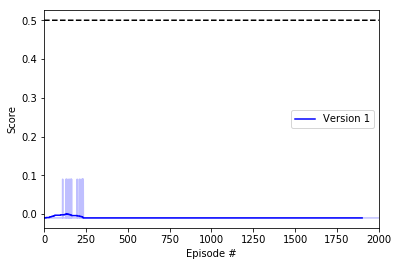

In [9]:
import numpy as np
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

from utils import utils
from utils.utils import ScoreParcels

score_parcels = [ScoreParcels('Version 1', './logs/log_DDPG_version_1.pickle', 'b'),]

utils.plot_scores_v2(score_parcels, 
                  size_window=100,
                 max_len=2000,
                 show_origin=True,
                  margin=0,
                 show_episode_on_label=True,
                    )